<a href="https://colab.research.google.com/github/annopol/entity-recognition/blob/main/Entity_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach inspired by a serie of articles on: https://towardsdatascience.com/practical-guide-to-entity-resolution-part-1-f7893402ea7e


Configuration of Spark session

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://dlcdn.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz

In [5]:
!tar xf spark-3.2.4-bin-hadoop3.2.tgz

In [6]:
!pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [7]:
!pip install findspark

In [8]:
!pip install graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.0 MB/s eta 0:00:00


In [9]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [10]:
import os, sys

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop3.2"

os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.2-spark3.2-s_2.12 pyspark-shell"

In [11]:
import findspark
findspark.init()

In [12]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

spark = SparkSession.builder.appName('Colab') \
    .config('spark.driver.memory', '16g') \
    .config('spark.executor.memory', '16g') \
    .config('spark.executor.cores', '8') \
    .config('spark.sql.shuffle.partitions', '100') \
    .getOrCreate()

In [13]:
spark.newSession()

In [14]:
#import of the developed module functions:
# %cd /content/gdrive/MyDrive/fiverrentity/data/
# import datasets
# sys.path.insert(0,'/content/gdrive/MyDrive/entity/')


#Path for the source datasets:
# path="/content/gdrive/MyDrive/Colab Notebooks/data/"
path="/"


In [15]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lit, col , row_number, concat, lower , trim
from pyspark.sql.window import Window


def load_data_mapping(spark: SparkSession, path ) -> DataFrame:
    """
    Load dataset Amzon_GoogleProducts_perfectMapping.csv

    Args:
        spark: Spark session
    Returns:
        Spark dataframe for Amazon & Google Product Mapping data
    """
    mapping = spark.read.csv(path+'Amzon_GoogleProducts_perfectMapping.csv', header=True)

    w = Window().orderBy(lit('A'))
    mapping=mapping.withColumn("mapIF", row_number().over(w))

    return mapping



def load_data_amazon(spark: SparkSession, path ) -> DataFrame:
    """
    Load dataset Amazon.csv

    Args:
        spark: Spark session
    Returns:
        Spark dataframe for Amazon  data
      """
    amazon = spark.read.csv(path+'Amazon.csv', header=True)
    amazon = amazon.withColumn("source", lit("Amazon"))\
            .withColumn("description", trim(lower("description")))\
            .withColumn('title', trim(lower(concat(col('title'), col('manufacturer')))))\

    return amazon


def load_data_google(spark: SparkSession, path ) -> DataFrame:
    """
    Load dataset GoogleProducts.csv

    Args:
        spark: Spark session
    Returns:
        Spark dataframe for GoogleProducts data
    """
    google = spark.read.csv(path+'GoogleProducts.csv', header=True)
    google = google.withColumnRenamed('name','title')\
            .withColumn("source", lit("Google"))\
            .withColumn("description", trim(lower("description")))\
            .withColumn('title', trim(lower(concat(col('title'), col('manufacturer')))))\

    return google

In [16]:
from pyspark.sql import functions as f
from pyspark.sql import types as t
from pyspark.sql import SparkSession
from pyspark.sql.session import SparkSession
from pyspark.context import SparkContext

from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, RegexTokenizer, CountVectorizer, StopWordsRemover, NGram, Normalizer, VectorAssembler, Word2Vec, Word2VecModel, PCA
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.linalg import VectorUDT, Vectors
import tensorflow_hub as hub
from pyspark.sql.functions import udf
import nltk
from nltk.stem.snowball import SnowballStemmer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer


def tokenize(df, string_cols):
    output = df
    for c in string_cols:
      output = output.withColumn('temp', f.coalesce(f.col(c), f.lit('')))
      tokenizer = RegexTokenizer(inputCol='temp', outputCol=c+"_tokens", pattern = "\\W")
        # stands for "word character", usually [A-Za-z0-9_]. Notice the inclusion of the underscore and digits.
      remover = StopWordsRemover(inputCol=c+"_tokens", outputCol=c+"_swRemoved")
      hashingTF = HashingTF(inputCol=c+"_swRemoved", outputCol=c+"_raw", numFeatures=40)

      idf = IDF(inputCol=c+"_raw", outputCol=c+"_features")
      output = tokenizer.transform(output)
      output = remover.transform(output)
      output = hashingTF.transform(output)
      idfModel = idf.fit(output)
      output = idfModel.transform(output)\
          .drop('temp', c+"_tokens")

    return output



def top_kw_from_tfidf(vocab, n=3):
  @udf(returnType=t.ArrayType(t.StringType()))
  def _(arr):
    inds = arr.indices
    vals = arr.values
    top_inds = vals.argsort()[-n:][::-1]
    top_keys = inds[top_inds]
    output = []

    for k in top_keys:
      kw = vocab.value[k]
      output.append(kw)

    return output
  return _


def tfidf_top_tokens(df, token_cols, min_freq=1):
  output = df
  for c in token_cols:
    pre = c
    cv = CountVectorizer(inputCol=pre, outputCol=pre+'_rawFeatures', minDF=min_freq)
    idf = IDF(inputCol=pre+"_rawFeatures", outputCol=pre+"_features", minDocFreq=min_freq)
    normalizer = Normalizer(p=2.0, inputCol=pre+"_features", outputCol=pre+'_tfidf')
    stages = [cv, idf, normalizer]
    pipeline = Pipeline(stages=stages)
    model = pipeline.fit(output)
    output = model.transform(output)\
      .drop(pre+'_rawFeatures', pre+'_features')

    cvModel = model.stages[0]
    vocab = spark.sparkContext.broadcast(cvModel.vocabulary)
    output = output.withColumn(pre+'_top_tokens', top_kw_from_tfidf(vocab, n=5)(f.col(pre+"_tfidf")))

  return output


# magic function to load model only once per executor
MODEL = None
def get_model_magic():
  global MODEL
  if MODEL is None:
      MODEL = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
  return MODEL

@udf(returnType=VectorUDT())
def encode_sentence(x):
  model = get_model_magic()
  emb = model([x]).numpy()[0]
  return Vectors.dense(emb)



Loading Datasets

In [21]:
mappings = load_data_mapping(spark, path)
df1 = load_data_amazon(spark, path)
df2 = load_data_google(spark, path)

In [22]:
# Join both product lists:
from pyspark.sql.functions import desc
source= df1.union(df2)
source = source.limit(2500)
test = source.orderBy(desc("id")).limit(1500)

In [23]:
type(source)

pyspark.sql.dataframe.DataFrame

Tokenization:

In [24]:
blocking_df= tokenize(source, ["description", "title"])
blocking_df_test = tokenize(source, ["description", "title"])

By tokenizing the text in the "description" and "title" columns of the source DataFrame, you are creating new features that may be useful for downstream tasks such as classification

**Blocking functions**

Definitions for transformation of the text into tokens and their normalization

Apply normalization to tokens:

In [25]:
blocking_df = tfidf_top_tokens(blocking_df, [c + '_swRemoved' for c in ['title', 'description']])
blocking_df_test = tfidf_top_tokens(blocking_df_test, [c + '_swRemoved' for c in ['title', 'description']])

 these imports are required to perform text preprocessing and feature engineering tasks on a PySpark DataFrame, such as tokenization, stop word removal, and TF-IDF vectorization, to prepare the data for a machine learning model.

Generate blocking keys

In [26]:
keep_cols = ['id','source', 'title', 'description',   'price',
              'title_swRemoved', 'description_swRemoved',
             'title_swRemoved_tfidf', 'description_swRemoved_tfidf',
             'title_encoding', 'description_encoding']
LARGEST_BLOCK = 5

# from spark_matcher.data import cand_pairs
# blok=cand_pairs.generate_pairs(blok, keep_cols, LARGEST_BLOCK)

from pyspark.sql import functions as f
blocking_df = blocking_df.withColumn('title_encoding', encode_sentence(f.coalesce(f.col('title'), f.lit(''))))\
  .withColumn('description_encoding', encode_sentence(f.coalesce(f.col('description'), f.lit(''))))\
  .withColumn('blocking_keys',
               f.array_union(f.col('title_swRemoved_top_tokens'), f.array_union(f.col('description_swRemoved_top_tokens'), f.col('title_swRemoved_top_tokens')))
             )
blocking_df_test = blocking_df_test.withColumn('title_encoding', encode_sentence(f.coalesce(f.col('title'), f.lit(''))))\
  .withColumn('description_encoding', encode_sentence(f.coalesce(f.col('description'), f.lit(''))))\
  .withColumn('blocking_keys',
               f.array_union(f.col('title_swRemoved_top_tokens'), f.array_union(f.col('description_swRemoved_top_tokens'), f.col('title_swRemoved_top_tokens')))
             )

This code is preparing the data for blocking, which is the process of grouping similar records together before applying the matching algorithm. The goal of blocking is to reduce the search space and improve the efficiency of the matching algorithm.



generate candidate pairs

In [27]:
keep_cols = ['id','source', 'title', 'description',  'price',
              'title_swRemoved', 'description_swRemoved',
             'title_swRemoved_tfidf', 'description_swRemoved_tfidf',
             'title_encoding', 'description_encoding']

LARGEST_BLOCK = 5

node = blocking_df.select(keep_cols)
node_test = blocking_df_test.select(keep_cols)
keep_pairs = blocking_df.select(f.explode('blocking_keys').alias('blocking_key'), 'id','source')\
  .groupBy('blocking_key')\
  .agg(
    f.count('id').alias('block_size'),
    f.countDistinct('source').alias('diff_source_cnt'),
    f.collect_set('id').alias('id'),
  )\
  .filter(f.col('block_size').between(2,LARGEST_BLOCK))\
  .select('blocking_key', f.explode('id').alias('id'))\
  .filter(f.col('diff_source_cnt') >1)

left = keep_pairs.withColumnRenamed('id', 'src')
right = keep_pairs.withColumnRenamed('id', 'dst')

candidate_pairs = left.join(right, ['blocking_key'], 'inner')\
  .filter(f.col('src') != f.col('dst'))\
  .select('src', 'dst')\
  .distinct()


The code above is creating candidate pairs of listings that may match based on shared blocking keys. The keep_cols variable defines the columns to keep in the output, which include the listing ID, source, title, description, price, title and description with stop words removed, title and description with stop words removed and represented as TF-IDF vectors, and title and description encoded using the Universal Sentence Encoder.

In [28]:
keep_pairs_test = blocking_df_test.select(f.explode('blocking_keys').alias('blocking_key'), 'id','source')\
  .groupBy('blocking_key')\
  .agg(
    f.count('id').alias('block_size'),
    f.countDistinct('source').alias('diff_source_cnt'),
    f.collect_set('id').alias('id'),
  )\
  .filter(f.col('block_size').between(2,LARGEST_BLOCK))\
  .select('blocking_key', f.explode('id').alias('id'))\
  .filter(f.col('diff_source_cnt') >1)

left_test = keep_pairs_test.withColumnRenamed('id', 'src')
right_test = keep_pairs_test.withColumnRenamed('id', 'dst')

candidate_pairs_test = left_test.join(right_test, ['blocking_key'], 'inner')\
  .filter(f.col('src') != f.col('dst'))\
  .select('src', 'dst')\
  .distinct()

**Create graph dataframe**

In [29]:
from graphframes import GraphFrame
g = GraphFrame(node, candidate_pairs)
g_test=GraphFrame(node_test,candidate_pairs_test)

In [ ]:
# node.show()

**Definitions for similarity calculation**




In [30]:
from functools import reduce
import operator

In [31]:
@udf("double")
def dot(x, y):
  if x is not None and y is not None:
    return float(x.dot(y))
  else:
    return 0

def null_safe_levenshtein_sim(c1, c2):
  output = f.when(f.col(c1).isNull() | f.col(c2).isNull(), 0)\
            .otherwise(1 - f.levenshtein(c1, c2) / f.greatest(f.length(c1), f.length(c2)))
  return output

def null_safe_num_sim(c1, c2):
  output = f.when(f.col(c1).isNull() | f.col(c2).isNull(), 0)\
            .when((f.col(c1) == 0) & (f.col(c2) == 0), 1)\
            .when((f.col(c1) == 0) | (f.col(c2) == 0), 0)\
            .otherwise(1 - f.abs(f.col(c1) - f.col(c2)) / f.greatest(c1, c2))
  return output

def null_safe_token_overlap(c1, c2):
  # is the overlap a significant part of the shorter string
  output = f.when(f.col(c1).isNull() | f.col(c2).isNull(), 0)\
            .when((f.size(f.array_distinct(c1)) == 0) | (f.size(f.array_distinct(c2)) == 0), 0)\
            .otherwise(f.size(f.array_intersect(c1, c2)) / f.least(f.size(f.array_distinct(c1)), f.size(f.array_distinct(c1))))
  return output

def calc_sim(df):
  df = df.withColumn('title_lev', null_safe_levenshtein_sim('src.title', 'dst.title'))\
      .withColumn('description_lev', null_safe_levenshtein_sim('src.description', 'dst.description'))\
      .withColumn('title_token_sim', null_safe_token_overlap('src.title_swRemoved', 'dst.title_swRemoved'))\
      .withColumn('description_token_sim', null_safe_token_overlap('src.description_swRemoved', 'dst.description_swRemoved'))\
      .withColumn('price_sim', null_safe_num_sim('src.price', 'dst.price'))\
      .withColumn('title_tfidf_sim', dot(f.col('src.title_swRemoved_tfidf'), f.col('dst.title_swRemoved_tfidf')))\
      .withColumn('description_tfidf_sim', dot(f.col('src.description_swRemoved_tfidf'), f.col('dst.description_swRemoved_tfidf')))\
      .withColumn('title_encoding_sim', dot(f.col('src.title_encoding'), f.col('dst.title_encoding')))\
      .withColumn('description_encoding_sim', dot(f.col('src.description_encoding'), f.col('dst.description_encoding')))

  metrics = ['description_lev', 'title_lev', 'price_sim', 'title_tfidf_sim', 'description_tfidf_sim',
             'title_encoding_sim', 'description_encoding_sim',
             'title_token_sim', 'description_token_sim'
            ]

  df = df.withColumn('overall_sim', reduce(operator.add, [f.col(c) for c in metrics]) / len(metrics))
  return df


distance_df = calc_sim(g.triplets)
distance_df_test = calc_sim(g_test.triplets)

In [ ]:
# distance_df.show()

The code defines several functions for calculating similarity measures between pairs of records, and applies them to a DataFrame containing pairs of records (triplets).The resulting distance_df and distance_df_test DataFrames contain the original triplets, as well as columns for each similarity measure and an overall similarity score. These DataFrames can be used to train and evaluate a matching model.


**Joining the information from the Perfect Mapping dataset**

In [32]:
from pyspark.sql.functions import col
#create training data by joining with perfect matching information:
distance_df2=distance_df.withColumn('src_id', f.col('edge.src'))\
             .withColumn('dst_id', f.col('edge.dst'))\
             .withColumn('diff_source', (f.col('src.source') != f.col('dst.source')).cast('integer'))

cond=((distance_df2.src_id==mappings.idAmazon) & (distance_df2.dst_id==mappings.idGoogleBase)) |\
       ((distance_df2.src_id==mappings.idGoogleBase) & (distance_df2.dst_id==mappings.idAmazon))

distance_df3=distance_df2.join(mappings, on=cond, how='left').distinct()\
          .withColumn('mapped_flg',  f.coalesce((f.col('mapIF')>0).cast('integer'),f.lit(0)))


In [33]:
distance_df2_test=distance_df_test.withColumn('src_id', f.col('edge.src'))\
             .withColumn('dst_id', f.col('edge.dst'))\
             .withColumn('diff_source', (f.col('src.source') != f.col('dst.source')).cast('integer'))

cond=((distance_df2_test.src_id==mappings.idAmazon) & (distance_df2_test.dst_id==mappings.idGoogleBase)) |\
       ((distance_df2_test.src_id==mappings.idGoogleBase) & (distance_df2_test.dst_id==mappings.idAmazon))

distance_df3_test=distance_df2_test.join(mappings, on=cond, how='left').distinct()\
          .withColumn('mapped_flg',  f.coalesce((f.col('mapIF')>0).cast('integer'),f.lit(0)))

In [34]:
# groupBy to check number of matched pairs:
prop=distance_df3.groupBy("mapped_flg").count()

In [ ]:
# prop.show()

**Creating dataframe for supervised modeling**

In [35]:
features = ['description_lev', 'title_lev', 'price_sim',
            'title_tfidf_sim', 'description_tfidf_sim',
            'title_token_sim', 'description_token_sim',
            'title_encoding_sim', 'description_encoding_sim']
from pyspark.ml.feature import StringIndexer

df_m = distance_df3
df_m_test = distance_df3_test

# assemble the vectors to make a final feature set
# feature_df = feature_df.withColumn('features', f.array(*[f.col(c) for c in features]))

assembler= VectorAssembler(inputCols= ['imputed_{}'.format(item) for item in features],
                           outputCol= "features",
                           handleInvalid="keep")

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_m = assembler.transform(df_m)
df_m_test = assembler.transform(df_m_test)

**Training of the model**

In [36]:
from pyspark.ml.classification import RandomForestClassifier
# param_grid = {'n_estimators': [50, 75, 100], 'max_depth': [11, 12, 13], 'max_features': ['log2', 'sqrt', None]}

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'mapped_flg', seed=1)
rf.setFeaturesCol("features")

# Taking 70% of both 0's and 1's into training set
train = df_m.sampleBy("mapped_flg", fractions={0: 0.5, 1: 0.8}, seed=10)

 # Subtracting 'train' from original 'data' to get test set
test = df_m_test.sampleBy("mapped_flg", fractions={0: 0.5, 1: 0.8}, seed=10)



In [59]:
test.count()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/content/spark-3.2.4-bin-hadoop3.2/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/content/spark-3.2.4-bin-hadoop3.2/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [37]:
rfModel = rf.fit(train)
predictions = rfModel.transform(df_m_test)
#print("Training Dataset Count: " + str(train.count()))
#print("Test Dataset Count: " + str(test.count()))

In [ ]:
# print (predictions.show(1))

In [38]:
from sklearn.metrics import confusion_matrix

y_true = predictions.select(['mapped_flg']).collect()
y_pred = predictions.select(['prediction']).collect()

cm = confusion_matrix(y_true, y_pred)
print(cm)


[[4299   93]
 [ 172  194]]


In [39]:
TP = cm[0, 0]
TN = cm[1, 1]
FP = cm[1, 0]
FN = cm[0, 1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1_score = 2 * precision * recall / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)
print("F1 Score:", f1_score)

Accuracy: 0.9443043295502311
Precision: 0.9615298590919258
Recall: 0.9788251366120219
Specificity: 0.5300546448087432
F1 Score: 0.9701004174658694


[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(50.722222222222214, 0.5, 'True label')]

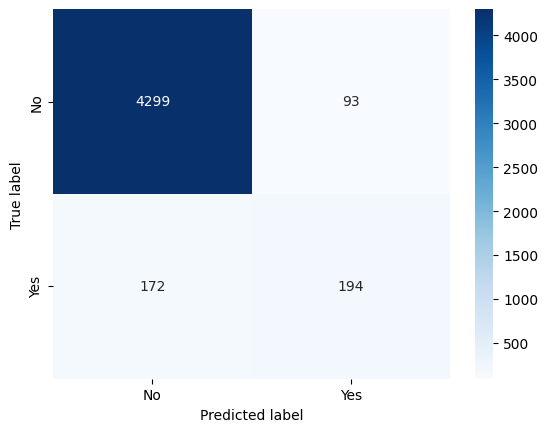

In [45]:
import seaborn as sns

s=sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
s.set(xlabel='Predicted label', ylabel='True label')

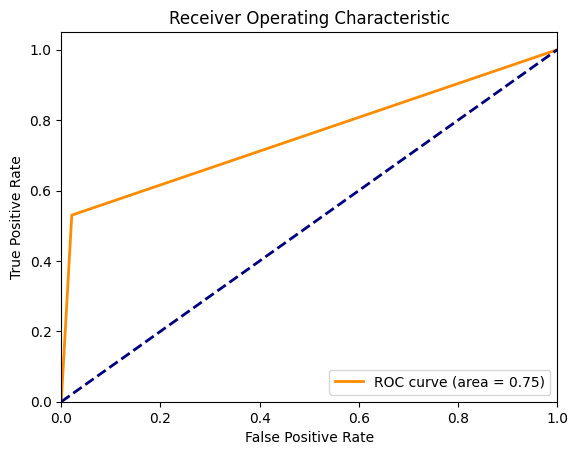

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# assuming you have defined the true labels as y_true and predicted probabilities as y_pred
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

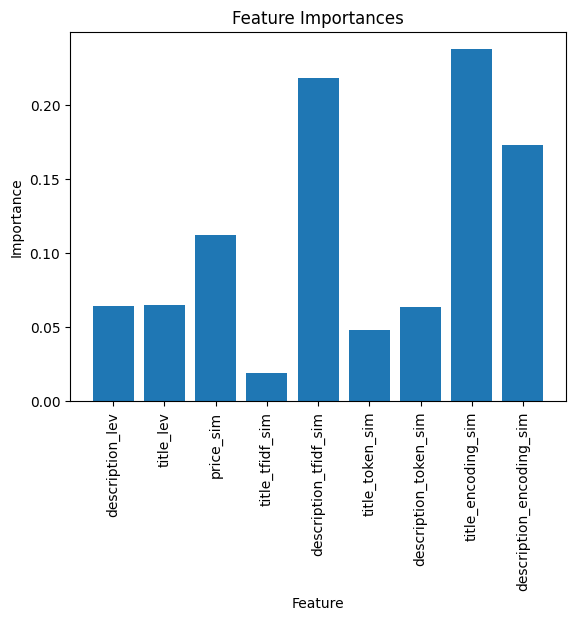

In [52]:
import matplotlib.pyplot as plt
importances = rfModel.featureImportances

# create a bar chart of feature importances
plt.bar(features, importances)

# set x-axis label
plt.xlabel('Feature')

# set y-axis label
plt.ylabel('Importance')

# set chart title
plt.title('Feature Importances')

# rotate x-axis labels to improve readability
plt.xticks(rotation=90)

# display the chart
plt.show()

**evaluating the model**

In [53]:
# initialize the evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="mapped_flg")
# calculate AUC
auc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})
print('Test AUC: %0.3f' % auc)


Test AUC: 0.936


/content/spark-3.2.4-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


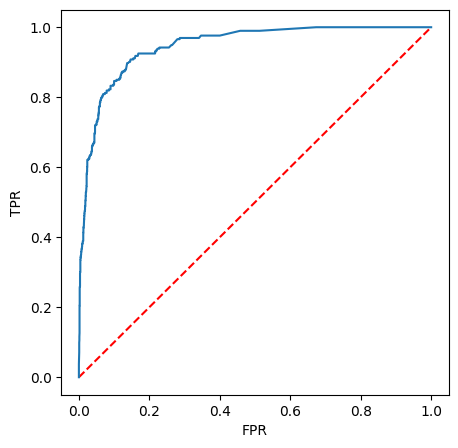

In [55]:
#Draw ROC curve:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(rfModel.summary.roc.select('FPR').collect(),
         rfModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

**Generate entities:**

In [58]:
##Generate entities:
predictions_pairs = rfModel.transform(df_m)

#Matched entities:
generated_entities=predictions_pairs.filter(predictions_pairs.prediction==1.0)
#apply the model on whole dataset

In [59]:
generated_entities.show(10)

+--------------------+--------------------+--------------------+---------+-------------------+---------------+---------------------+------------------+---------------+---------------------+--------------------+------------------------+-------------------+--------------------+--------------------+-----------+----------+--------------------+-----+----------+--------------------+--------------------+--------------------+----------+
|                 src|                edge|                 dst|title_lev|    description_lev|title_token_sim|description_token_sim|         price_sim|title_tfidf_sim|description_tfidf_sim|  title_encoding_sim|description_encoding_sim|        overall_sim|              src_id|              dst_id|diff_source|  idAmazon|        idGoogleBase|mapIF|mapped_flg|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+---------+-------------------+---------------+---------------------+--